In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import importlib
import pandas as pd
import seaborn
from IPython.display import Image
import matplotlib.pyplot as plt

import Transformer as tnsf
import preprocess as ad

import sys
import copy
from matplotlib.colors import LogNorm
np.set_printoptions(threshold=sys.maxsize)

importlib.reload(ad)
importlib.reload(tnsf)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cuda"
print(device)

cuda


In [9]:
def test_generate(name, window_size=10):
    hdfs = set()
    # hdfs = []
    with open( name, 'r') as f:
        for ln in f.readlines():
            ln = list(map(lambda n: n, map(int, ln.strip().split())))
#             ln = ln + [0] * (window_size + 1 - len(ln))
            hdfs.add(tuple(ln))
            # hdfs.append(tuple(ln))
    print('Number of sessions({}): {}'.format(name, len(hdfs)))
    return hdfs

In [10]:
importlib.reload(ad)

<module 'preprocess' from '/mnt/data/tad/preprocess.py'>

In [11]:
def create_mat(dataloader, model, layers, heads, file, enc =True, dec = False):
    
    enc_att = np.zeros((449,449))
    enc_tp_att = np.zeros((449,449))
    enc_fn_att = np.zeros((449,449))
    
    if dec:
        dec_att = np.zeros((449,449))
        dec_tp_att = np.zeros((449,449))
        dec_fn_att = np.zeros((449,449))
    
    src_mask = Variable(torch.ones(1, 1, window_size + 1)).to(device)
    bos = torch.ones((1, ),dtype = int).to(device)
    
#     print("********** ********** ********** ********** **********")
#     print("      ********** FIRST INPUT SEQUENCE ********** ")
#     print("********** ********** ********** ********** **********")
#     print("\n")
    sequence_cnt = 10
    anomaly_timeline = []
    line_number = 1
    for line in dataloader:
        if line_number%25==0:
            print("Current Sequence Number:",line_number)
        else:
            pass
        line_number += 1
        for i in range(len(line) - window_size):
            seq = line[i:i + window_size]
            
            #for predicting 10
            label = line[i+window_size:(i+window_size)+window_size]
            
            #for predicting only 1
            ###label = line[i+window_size:(i+window_size)+1]
            ###print("Sequence: {}".format(seq))
            ###ad.backtrace(seq, "linux.log", "Spell")
            

            t1 = torch.cat((bos, torch.tensor(seq, dtype = torch.int).to(device))).unsqueeze(0)
            t2 = torch.tensor(label, dtype = torch.int).to(device).unsqueeze(0)

            src = Variable(t1, requires_grad =False)
            tgt = Variable(t2, requires_grad =False)

#             print("---------- ---------- ---------- ---------- ----------")
#             print("Input Sequence: {}".format(seq))
#             print("Label: {}".format(label))
#             print("\n")

#             print("~~~~~~~~~~ ATTENTION WEIGHTS ON GREEDY DECODE ~~~~~~~~~~")
#             print("\n")
            ###tgt_pred = tnsf.predict(model, src, src_mask, tgt, max_len = len(tgt)+1, start_symbol = 1, g = 10)
            ###tgt_pred = tnsf.greedy_decode(model, src, src_mask, tgt, len(label)+1, 1, True, g=10, halt = True, layers = layers, heads = heads)
            tgt_pred, candidates = tnsf.greedy_decode(model, src, src_mask, tgt, 2, 1, True, g=10, halt = True, layers = layers, heads = heads)

            # List for every deteected anomaly
            if tgt_pred.cpu().detach().numpy() in candidates.cpu().detach().numpy():
                anomaly_timeline.append(0)
            else:
                anomaly_timeline.append(1)
                
            ###print("---------- ---------- ---------- ---------- ----------")
            ###print("Input Sequence: {}".format(seq))
            ###print("Label: {}".format(label))
            ###print("Pred: {}".format(tgt_pred[0][0]))

            print("\n")
            print("~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~")
            ad.backtrace(seq, "linux.log", "Spell")
            print("\n")
            print("~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~")
            ad.backtrace(label[:1], "linux.log", "Spell") 
            print("\n")
            print("~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~")
            ###ad.backtrace(tuple(tgt_pred.cpu().detach().numpy()[0]) , "linux.log", "Spell")
            ad.backtrace(tuple(np.flip(candidates.cpu().detach().numpy()[6:])) , "linux.log", "Spell")
            print("\n")
            
            enc_weights = 0
            
            for layer in range(layers):
                for h in range(heads):
                    ###print("Layer:{} , Head: {}".format(layer,h))
                    enc_weights += model.encoder.layers[layer].self_attn.attn[0, h].data[:len(label), 1:len(seq)+1][0]
                    ###print("~~~~~~~~~~ ENCODER ATTENTION WEIGHTS ~~~~~~~~~~")
                    ###print(enc_weights)
                    ###print("\n")
                    
            if dec:
                dec_weights = 0
                for layer in range(layers):
                    for h in range(heads):
                        ###print("Decoder Layer:{} , Head: {}".format(layer,h))                    
                        dec_weights += model.decoder.layers[layer].self_attn.attn[0, h].data[:len(label), :len(seq)][0]
                        ###if you are predicting 10 use the code below
                        ###dec_weights += model.decoder.layers[layer].self_attn.attn[0, h].data[:len(label), :len(seq)]
                        ###print("~~~~~~~~~~ DECODER ATTENTION WEIGHTS ~~~~~~~~~~")
                        ###print(dec_weights)
                        ###print("\n")
            
#             print("########## END OF INFO FOR LOG SEQUENCE {} ##########".format(sequence_cnt))
#             print("\n")
#             print("\n")
#             print("\n")

            sequence_cnt += 1
            
#             print("********** ********** ********** ********** **********")
#             print("     ********** INPUT SEQUENCE {} - {} **********".format(sequence_cnt-9,sequence_cnt))
#             print("********** ********** ********** ********** **********")
#             print("\n")
            
            ###print(label[0],tgt_pred.cpu().detach().numpy())
            ###print(label[0] in tgt_pred.cpu().detach().numpy())
            ###if label[0] not in tgt_pred.cpu().detach().numpy():
            ###    print(label[0],tgt_pred)
            ###else:
            ###    pass
            
            for i in range(len(tgt_pred)):
#             uncomment if you are using 10 predictions instead of 1
                for j in range(len(tgt_pred)):
                        enc_att[seq[i],label[j]] += enc_weights[i]  
#                 enc_att[seq[i], label[0]] += enc_weights[i]

            
            if -1 in tgt_pred:
                for i in range(len(tgt_pred)):
                #uncomment if you are using 10 predictions instead of 1
                    for j in range(len(tgt_pred)):
                        enc_tp_att[seq[i],label[j]] += enc_weights[i]
#                     enc_tp_att[seq[i],label[0]] += enc_weights[i]
            else:
                for i in range(len(tgt_pred)):
                #uncomment if you are using 10 predictions instead of 1
                    for j in range(len(tgt_pred)):
                        enc_fn_att[seq[i],label[j]] += enc_weights[i]    
#                     enc_fn_att[seq[i], label[0]] += enc_weights[i]
            
            if dec:
                for i in range(len(tgt_pred)):
                    for j in range(len(tgt_pred)):
                        dec_att[seq[i], label[j]] += dec_weights[i]

                if -1 in tgt_pred:
#                    print("halt")
                    for i in range(len(tgt_pred)):
                        for j in range(len(tgt_pred)):
                            dec_tp_att[seq[i],label[j]] += dec_weights[i]
                else:
                    for i in range(len(tgt_pred)):
                        for j in range(len(tgt_pred)):
                            dec_fn_att[seq[i], label[j]] += dec_weights[i]    
            

#     with open("decoder_attentions/all_" + file + '_attention.npy', 'wb') as f:
#         np.save(f, enc_att)
                        
#     with open("decoder_attentions/tp_" + file + '_attention.npy', 'wb') as f:
#         np.save(f, enc_tp_att)
        
#     with open("decoder_attentions/fn_" + file + '_attention.npy', 'wb') as f:
#         np.save(f, enc_fn_att)        
    
    enc_att_normalized =(enc_att-np.min(enc_tp_att))/(np.max(enc_att)-np.min(enc_att))
    enc_tp_att_normalized =(enc_tp_att-np.min(enc_tp_att))/(np.max(enc_tp_att)-np.min(enc_tp_att))
    enc_fn_att_normalized =(enc_fn_att-np.min(enc_fn_att))/(np.max(enc_fn_att)-np.min(enc_fn_att))
#     print(enc_fn_att_normalized[enc_fn_att_normalized>0])
    if dec:
        dec_att_normalized =(dec_att-np.min(dec_tp_att))/(np.max(dec_att)-np.min(dec_att))
        dec_tp_att_normalized =(dec_tp_att-np.min(dec_tp_att))/(np.max(dec_tp_att)-np.min(dec_tp_att))
        dec_fn_att_normalized =(dec_fn_att-np.min(dec_fn_att))/(np.max(dec_fn_att)-np.min(dec_fn_att))

#     with open("decoder_attentions/all_" + file + '_normalized_attention.npy', 'wb') as f:
#             np.save(f, enc_att_normalized)  
#     with open("decoder_attentions/tp_" + file + '_normalized_attention.npy', 'wb') as f:
#             np.save(f, enc_tp_att_normalized)  
#     with open("decoder_attentions/fn_" + file + '_normalized_attention.npy', 'wb') as f:
#             np.save(f, enc_fn_att_normalized)              

    # Plot Anomaly Detection Timeline
    fig = plt.figure(figsize = (15, 5))
    x = range(11,len(anomaly_timeline)+11)
    plt.xlabel("Log Timeline", fontsize=14)
    plt.ylabel("Anomaly = 1, Normal =0", fontsize=14)
    plt.title("Anomaly Detection Timelline", fontsize=14)
    plt.bar(x, anomaly_timeline, color = "blue")
    plt.xlim([11, len(anomaly_timeline)+11])
    #plt.setp(axs[1], yscale = 'log', xlabel="Log Key (Input Sequences)")
    plt.tight_layout()
    # plt.savefig('GonnaCry_bar_all.png')
    plt.show()        
            
#     return (enc_att_normalized, enc_tp_att_normalized, enc_fn_att_normalized), (dec_att_normalized, dec_tp_att_normalized, dec_fn_att_normalized)
    return (enc_att_normalized, enc_tp_att_normalized, enc_fn_att_normalized)

In [12]:
test_abnormal_loader = test_generate("Dataset/Linux/abnormallinux_utrojan-t1036-004")

Number of sessions(Dataset/Linux/abnormallinux_utrojan-t1036-004): 1


In [13]:
model = torch.load("Model/global_models_practicum.pt")

In [14]:
# Model information
layers = 1
heads = 1
WINDOW_SIZE = 10
window_size = 10
importlib.reload(ad)
importlib.reload(tnsf)

<module 'Transformer' from '/mnt/data/tad/Transformer.py'>

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 20, 269,  19,  17, 264,   5,   7,  11,   8, 260], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0366 0.0372 0.0405 0.0568 0.0600 0.0704 0.0883 0.1057 0.1243 0.3803], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2066 0.0000 0.1931 0.4281 0.5852 0.6507 0.7135 1.0000 0.5216 0.3034]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
418 204    Starting Docker Application Container Engine...
258 159    time <*> <*>"" level info msg ""Starting up""
259 160    time <*> <*>"" level info msg ""detected <*> n...
224 112    [ <*>.<*>] audit type <*> audit <*>.<*> <*> <*>
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([271,   7, 264,  17,   3, 265,  13, 164,  20,   5], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0520 0.0523 0.0911 0.0932 0.0941 0.0947 0.1087 0.1194 0.1324 0.1621], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1894 0.0997 0.3854 0.2252 1.0000 0.5633 0.0000 0.0981 0.0425 0.0821]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
263 161    time <*> <*>"" level info msg ""[gr

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))


260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
260 73    time <*> <*>"" level info msg <*> <*> <*> modu...
263 161    time <*> <*>"" level info msg ""[graphdriver] ...
264 95    time <*> <*>"" level warning msg ""Your kernel...
264 95    time <*> <*>"" level warning msg ""Your kernel...
264 95    time <*> <*>"" level warning msg ""Your kernel...
164 107    time <*> <*>"" level info msg ""Loading contai...
265 151    <*> <*> Bridge firewalling registered
266 150    <*> <*> Initializing XFRM netlink socket
267 145    <*> <*> Netfilter messages via NETLINK v0.<*>.


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
268 144    <*> <*> ctnetlink v0.<*> registering with nfne...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
7 15    Network configuration changed trying to establ...
268 144    <*> <*> ctnetlink v0.<*> registering with nfne...
8 2    Starting <*> Service...
269 125    link_config autonegotiation is unset or enable...


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))



271 143    <*> Link UP
164 107    time <*> <*>"" level info msg ""Loading contai...


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
168 131    time <*> <*>"" level info msg ""Docker daemon"...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
7 15    Network configuration changed trying to establ...
3 25    Server returned error NXDOMAIN mitigating pote...
117 103    daemon.go <*> <*> waiting for running hooks
19 16    Synchronized to time server <*> <*> <*> .


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 78, 164,   3,  66,   7, 199, 271,  67, 170, 169], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0556 0.0595 0.0648 0.0662 0.0680 0.0878 0.1060 0.1095 0.1547 0.2279], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.5950 0.0000 1.0000 0.6406 0.3155 0.4286 0.7671 0.8275 0.9462 0.4651]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
164

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeW

9 12    Started ntp-systemd-netif.service.


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
12 9    systemd-hostnamed.service Failed to set up mou...
9 12    Started ntp-systemd-netif.service.
5 8    ens3 DHCP lease lost
17 1    Could not set hostname Method call timed out


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([117,  12,  81,   3,  11,  19,  44,  26,   5,  17], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0145 0.0147 0.0154 0.0277 0.0369 0.0390 0.0459 0.1591 0.2432 0.4036], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.1650 0.2648 1.0000 0.3426 0.1564 0.2218 0.0802 0.8629 0.1320]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
269 125    link_config auto

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-pac

17 1    Could not set hostname Method call timed out
7 15    Network configuration changed trying to establ...
19 16    Synchronized to time server <*> <*> <*> .
5 8    ens3 DHCP lease lost


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([45, 16, 26, 20,  5, 17,  6, 12,  9, 10], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0052 0.0052 0.0058 0.0071 0.0076 0.0255 0.0313 0.0538 0.0625 0.7959], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0709 0.0533 0.0000 0.6234 0.1038 0.1309 1.0000 0.4123 0.1448 0.1078]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
169 133    time <*> <*>"" level info msg ""Daemon has com...
171 123    time <*> <*>"" level info msg ""API listen on ...
170

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/


12 9    systemd-hostnamed.service Failed to set up mou...
9 12    Started ntp-systemd-netif.service.


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([44, 19,  9, 26, 20,  5, 10, 12, 17, 11], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0236 0.0243 0.0251 0.0438 0.0586 0.0900 0.1605 0.1776 0.1881 0.2084], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0650 0.3896 0.0000 0.4729 0.5001 0.8517 0.7166 0.1699 0.4772 1.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
420 201    Stopping Network Time Service...
421 200    ntpd exiting on signal <*> Terminated
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
8 2    Starting <*> Service...
448 446 

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/


19 16    Synchronized to time server <*> <*> <*> .


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 22, 209,  32, 120,  67, 118, 191, 110,   5,  17], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0557 0.0578 0.0656 0.0682 0.0708 0.0733 0.0762 0.0784 0.2027 0.2513], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0717 0.0360 0.0000 0.1192 0.1461 0.3365 0.8146 0.3558 0.5829 1.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
448 446    [ <*>.<*>] audit type <*> audit <*>.<*> <*> ap...
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.
426 196    proto precision <*>.<*> usec <*>

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeW




^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([66, 15, 81, 18, 44,  3, 13, 11,  7,  8], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0359 0.0431 0.0431 0.0432 0.0475 0.0557 0.0634 0.0781 0.0904 0.4995], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.4721 0.0000 0.6269 1.0000 0.4121 0.0000 0.0000 0.0853 0.2490 0.1143]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
427 202    leapsecond file '/usr/share/zoneinfo/leap-seco...
428 198    leapsecond file '/usr/share/zoneinfo/leap-seco...
429 147    Listen and drop on <*> <*> <*>
429 147    Listen and drop on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
431 197    Listening on routing socket on fd #<*> for int...
440 206    [ <*>.<*>] [UFW BLOCK] IN ens3 OUT MAC fa <*> ...
440 206    [ <*>.<*

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([12, 44, 19, 26,  7, 15,  5,  9, 17,  8], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0400 0.0478 0.0496 0.0515 0.0556 0.0769 0.0877 0.0914 0.1135 0.3860], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1009 0.1811 0.0278 0.3072 0.0000 1.0000 0.1933 0.2689 0.3273 0.5512]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
431 197    Listening on routing socket on fd #<*> for int...
440 206    [ <*>.<*>] [UFW BLOCK] IN ens3 OUT MAC fa <*> ...
440 206    [ <*>.<*>] [UFW BLOCK] IN ens3 OUT MAC fa <*> ...
11 0    ens3 Configured
9 12    Started ntp-system

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0165 0.0192 0.0223 0.0271 0.0573 0.0721 0.1111 0.1162 0.2462 0.3120], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.5822 0.0000 0.0294 0.3482 0.7934 1.0000 0.4617 0.4918 0.0925 0.5968]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
11 0    ens3 Configured
9 12    Started ntp-systemd-netif.service.
420 201    Stopping Network Time Service...
421 200    ntpd exiting on signal <*> Terminated
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
8 2    Starting <*> Service...
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.


~~~~~~~~~~ LABEL BACKTRACE ~~~~

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/

Probabilities:  tf.Tensor([0.0369 0.0404 0.0404 0.0411 0.0615 0.0704 0.1108 0.1138 0.1645 0.3202], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0124 0.0350 0.0485 0.0161 0.0000 0.2675 0.3290 1.0000 0.3257 0.1096]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
422 194    Stopped Network Time Service.
8 2    Starting <*> Service...
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.
426 196    proto precision <*>.<*> usec <*>
427 202    leapsecond file '/usr/share/zoneinfo/leap-seco...
428 198    leapsecond file '/usr/share/zoneinfo/leap-seco...
429 147    Listen and drop on <*> <*> <*>
429 147    Listen and drop on <*> <*> <*>


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-pac

~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
431 197    Listening on routing socket on fd #<*> for int...
11 0    ens3 Configured
9 12    Started ntp-systemd-netif.service.
420 201    Stopping Network Time Service...
421 200    ntpd exiting on signal <*> Terminated
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
8 2    Starting <*> Service...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
17 1    Could not set hostname Method call timed out
5 8    ens3 DHCP lease lost
11 0    ens3 Configured
6 6    [system] Activating via systemd service name '...


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([44, 62, 11, 26, 19,  5, 17,  9, 12, 10], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0063 0.0084 0.0087 0.0

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

9 12    Started ntp-systemd-netif.service.
420 201    Stopping Network Time Service...
421 200    ntpd exiting on signal <*> Terminated
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
8 2    Starting <*> Service...
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.
426 196    proto precision <*>.<*> usec <*>


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
427 202    leapsecond file '/usr/share/zoneinfo/leap-seco...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
10 7    ens3 DHCPv4 address <*>/<*> via <*>
11 0    ens3 Configured
5 8    ens3 DHCP lease lost
17 1    Could not set hostname Method call timed out


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([16, 26,  4, 20, 19, 77,  5, 10, 17, 11], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0050 0.0055 0.0069 0.0081 0.0088 

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 


425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.
426 196    proto precision <*>.<*> usec <*>
427 202    leapsecond file '/usr/share/zoneinfo/leap-seco...
428 198    leapsecond file '/usr/share/zoneinfo/leap-seco...
429 147    Listen and drop on <*> <*> <*>
429 147    Listen and drop on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
430 117    Listen normally on <*> <*> <*>


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
11 0    ens3 Configured
5 8    ens3 DHCP lease lost
17 1    Could not set hostname Method call timed out
22 38    Started Cleanup of Temporary Directories.


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([203,   3,  20,  34,  19,  26,  10,   5,  17,  11], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0296 0.0296 0.0392 0.0395 0.0396 0.0443 0.0655 0.1431 0.2705 0.2991], shape=(10,), dty

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeW


429 147    Listen and drop on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
431 197    Listening on routing socket on fd #<*> for int...
11 0    ens3 Configured
9 12    Started ntp-systemd-netif.service.


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
420 201    Stopping Network Time Service...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
5 8    ens3 DHCP lease lost
17 1    Could not set hostname Method call timed out
26 13    Low random number entropy available <*>
19 16    Synchronized to time server <*> <*> <*> .


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([  3,  18,  26, 198,  44,  19,  13,  12,  17,   5], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0460 0.0468 0.0557 0.0564 0.0676 0.0701 0.0733 0.1281 0.2080 0.2479], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
8 2    Starting <*> Service...


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
10 7    ens3 DHCPv4 address <*>/<*> via <*>
9 12    Started ntp-systemd-netif.service.
12 9    systemd-hostnamed.service Failed to set up mou...
17 1    Could not set hostname Method call timed out


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([81, 66, 95, 28, 22, 17, 11,  9, 12, 10], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0118 0.0124 0.0136 0.0167 0.0224 0.0276 0.0441 0.1216 0.2095 0.5202], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2947 0.0551 0.8216 0.0000 0.2197 1.0000 0.7713 0.4072 0.1543 0.2687]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

428 198    leapsecond file '/usr/share/zoneinfo/leap-seco...


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
16 5    Failed to start <*>
11 0    ens3 Configured
17 1    Could not set hostname Method call timed out
81 31    debug running <*> on /dev/sda<*>


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([44, 96, 11, 81,  7, 15, 13,  5, 17,  4], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0515 0.0531 0.0642 0.0764 0.0788 0.0945 0.0950 0.1067 0.1847 0.1950], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1716 0.1325 0.0137 0.0977 1.0000 0.0000 0.1013 0.9505 0.3206 0.8511]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
421 200    ntpd exiting on signal <*> Terminated
423 1

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeW

17 1    Could not set hostname Method call timed out
5 8    ens3 DHCP lease lost
19 16    Synchronized to time server <*> <*> <*> .
32 28    Started Message of the Day.


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 27,  32,  36, 117,   3,  26,  19,  11,   5,  17], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0225 0.0235 0.0274 0.0277 0.0292 0.0471 0.0619 0.1056 0.2622 0.3932], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0274 0.1007 0.1579 0.0000 1.0000 0.4555 0.0000 0.3832 0.4901 0.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.
426 196    proto precision <*>.<*> usec

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-pac

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([53, 44, 19,  3, 26,  9,  5, 17, 12, 10], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0093 0.0163 0.0164 0.0177 0.0279 0.0535 0.0938 0.0949 0.1872 0.4830], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0602 0.9239 0.1089 0.1128 0.3561 1.0000 0.3138 0.1598 0.3313 0.0000]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
431 197    Listening on routing socket on fd #<*> for int...
11 0    ens3 Configured
9 12    Started ntp-systemd-netif.service.
420 201    Stopping Network Time Service...
421 200    ntpd exiting on signal <*> Terminated
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
8 2    Starting

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
8 2    Starting <*> Service...
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.
426 196    proto precision <*>.<*> usec <*>
427 202    leapsecond file '/usr/share/zoneinfo/leap-seco...
428 198    leapsecond file '/usr/share/zoneinfo/leap-seco...
429 147    Listen and drop on <*> <*> <*>


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
429 147    Listen and drop on <*> <*> <*>


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
10 7    ens3 DHCPv4 address <*>/<*> via <*>
17 1    Could not set hostname Method call timed out
11 0    ens3 Configured
12 9    systemd-hostnamed.service Failed to set up mou...


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 41,  12,  36, 203,   9,  49,   5,  17,   7,  10], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 


429 147    Listen and drop on <*> <*> <*>
429 147    Listen and drop on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
431 197    Listening on routing socket on fd #<*> for int...


~~~~~~~~~~ LABEL BACKTRACE ~~~~~~~~~~
11 0    ens3 Configured


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
17 1    Could not set hostname Method call timed out
11 0    ens3 Configured
5 8    ens3 DHCP lease lost
19 16    Synchronized to time server <*> <*> <*> .


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([21, 87, 18, 44, 19, 26,  9, 17,  5, 12], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0032 0.0034 0.0062 0.0369 0.0434 0.0758 0.1028 0.2053 0.2380 0.2851], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.3068 1.0000 0.1881 0.1879 0.0000 0.1

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

422 194    Stopped Network Time Service.


~~~~~~~~~~ PREDICTION BACKTRACE [Top 4] ~~~~~~~~~~
17 1    Could not set hostname Method call timed out
5 8    ens3 DHCP lease lost
26 13    Low random number entropy available <*>
19 16    Synchronized to time server <*> <*> <*> .


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 71, 110,   6,  20,   7,   5,   8,  44,  17,  15], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0346 0.0387 0.0494 0.0644 0.0647 0.0798 0.0972 0.1017 0.2103 0.2591], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.2772 0.2549 0.0637 0.9274 0.2151 0.3336 0.8825 1.0000 0.2270]




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
431 197    Listening on routing socket on fd #<*> for int...
11

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

11 0    ens3 Configured
13 10    systemd-hostnamed.service Failed at step NAMES...
10 7    ens3 DHCPv4 address <*>/<*> via <*>
401 17    <*> mDNS multicast group on interface <*> with...


^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 81,  26, 120,  44,  19,  17,   5,  12,  10,  11], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0231 0.0233 0.0237 0.0262 0.0291 0.0682 0.0795 0.0923 0.1407 0.4940], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.0581 0.3444 1.0000 0.1949 0.2460 0.3416 0.1001 0.2004 0.2613]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
9 12    Started ntp-systemd-netif.service.
420 201    Stopping Network Time Service...
421 200    ntpd exiting on sign

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([ 22,   5,  17,  36, 203,   4,  32,  77,  10,  11], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0512 0.0563 0.0619 0.0620 0.0770 0.0796 0.1118 0.1165 0.1894 0.1943], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0513 0.0734 0.0000 0.0672 0.2407 0.8652 1.0000 0.3276 0.1012 0.3849]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
8 2    Starting <*> Service...
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.
426 196    proto precision <*>.<*> usec <*>
427 202    leapsecond file '/usr/share/zoneinfo/leap-seco...
428 198    leapsecond 

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-pac

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([105,   3,  12,  11,  34,  44,  19,  26,  17,   5], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0079 0.0101 0.0110 0.0116 0.0162 0.0275 0.0520 0.0712 0.3401 0.4524], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.2370 0.4404 0.3962 0.0000 0.8584 0.0000 0.4655 0.0817 1.0000 0.1438]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
427 202    leapsecond file '/usr/share/zoneinfo/leap-seco...
428 198    leapsecond file '/usr/share/zoneinfo/leap-seco...
429 147    Listen and drop on <*> <*> <*>
429 147    Listen and drop on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
430 117    Listen

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

tensor([ 32, 110,  26,   3,  62,   5,  17,   9,  12,  10], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0044 0.0045 0.0045 0.0054 0.0073 0.0097 0.0111 0.0346 0.0902 0.8284], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.1197 0.0303 0.0000 0.3891 0.0234 0.2155 1.0000 0.7945 0.3526 0.0333]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
430 117    Listen normally on <*> <*> <*>
430 117    Listen normally on <*> <*> <*>
431 197    Listening on routing socket on fd #<*> for int...
11 0    ens3 Configured
9 12    Started ntp-systemd-netif.service.
420 201    Stopping Network Time Service...
421 200    ntpd exiting on signal <*> Terminated
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([14,  9, 49,  7, 28, 13, 60,  4, 10, 16], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0575 0.0602 0.0608 0.0662 0.0676 0.0741 0.0803 0.1212 0.1741 0.2379], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0000 0.2179 1.0000 0.1317 0.0846 0.4498 0.0963 0.1465 0.1889 0.6032]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
420 201    Stopping Network Time Service...
421 200    ntpd exiting on signal <*> Terminated
423 109    <*> local addr <*> -> <null>
422 194    Stopped Network Time Service.
8 2    Starting <*> Service...
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...

/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: RuntimeWarning: invalid value encountered in true_divide
  normalized_weights =(att-np.min(att))/(np.max(att)-np.min(att))
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/mnt/data/tad/Transformer.py:495: 

^^^^^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Candidate logs:  tensor([  4, 203,  13,   5,  41,  22,  36,  17,  20,  11], device='cuda:0')


~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Probabilities:  tf.Tensor([0.0565 0.0602 0.0787 0.0845 0.0945 0.1020 0.1021 0.1098 0.1334 0.1784], shape=(10,), dtype=float32) 



~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~ ~~~~~~~~~~
Encoder Attention Normalized [0.0126 0.0000 0.1229 0.0705 0.2054 1.0000 0.3598 0.2580 0.1262 0.0652]


|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||
        >>>>>>>>>> ANOMALY DETECTED <<<<<<<<<<
|||||||||| |||||||||| |||||||||| |||||||||| ||||||||||




~~~~~~~~~~ SEQUENCE BACKTRACE ~~~~~~~~~~
424 195    ntpd <*>.<*>.8p10@<*>.<*>-o <*> Starting
425 199    Command line /usr/sbin/ntpd -p /var/run/ntpd.p...
327 193    Started Network Service.
426 196    proto precision <*>.<*> usec <*>
427 202    leapsecond file '/usr/share/zoneinfo/leap-seco...
428 198    leapsecond file '/usr/share/zoneinfo/leap-

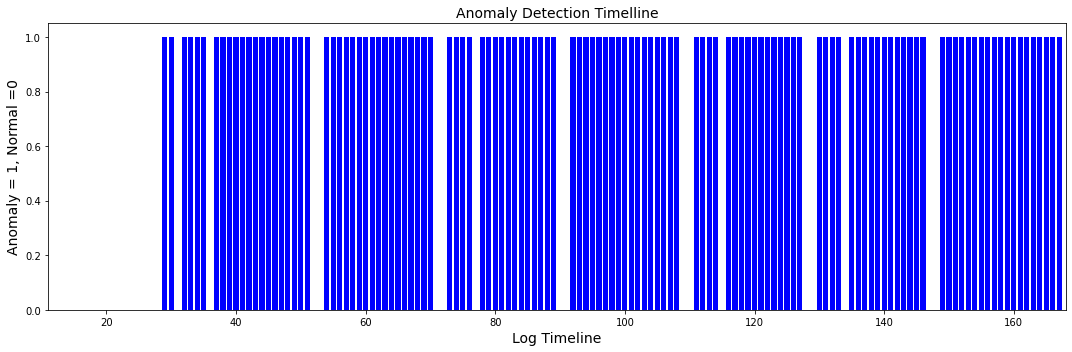

In [15]:
#print backtrack of logs
#tp att are for true positives
#fn att are for false negatives

att, tp_att, fn_att = create_mat(test_abnormal_loader, model, layers, heads, "utrojan", enc=True, dec=False)
